# A `qit` implementation of the CHIPPR algorithm

_Eric Charles & Alex Malz_

This notebook demonstrates a real use case of `qit`, to reproduce the results of [CHIPPR](https://arxiv.org/abs/2007.12178).

In [1]:
# imports
import numpy as np
import qp
import qit
from scipy.optimize import minimize
%matplotlib inline

## Emulating mock data

### True redshift distribution $n^{\dagger}(z)$

First, we make a true distribution.  
For this simple example, it is just a Gaussian

`true_dist` = $n^{\dagger}(z) = p(z | \phi^{\dagger})$

Note that we use the `scipy.stats.truncnorm` distribution to ensure that the PDF is normalized correctly.
Note also that the limits of truncnorm are expressed in terms of sigma.

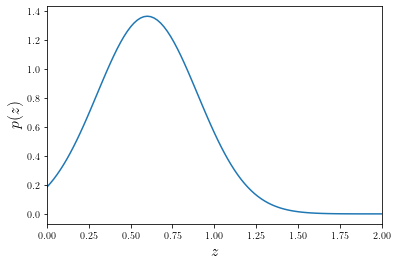

In [2]:
Z_TRUE_MIN, Z_TRUE_MAX = 0., 2.
LOC_TRUE = 0.60
SCALE_TRUE = 0.30
TRUNC_MIN = (Z_TRUE_MIN-LOC_TRUE)/SCALE_TRUE
TRUNC_MAX = (Z_TRUE_MAX-LOC_TRUE)/SCALE_TRUE

true_dist = qp.Ensemble(qp.stats.truncnorm, data=dict(a=TRUNC_MIN, b=TRUNC_MAX, loc=LOC_TRUE, scale=SCALE_TRUE))
ax_true = true_dist.plot(xlim=(Z_TRUE_MIN, Z_TRUE_MAX), label=r"unnorm")

### A redshift estimator's implicit prior $n^{*}(z)$

Now we make the implicit prior corresponding to a hypothetical estimator.  
In our case it is similiar to the true redshift distribution, but slightly different.

implicit_prior = $n^{*}(z) = p(z|\phi^{*})$

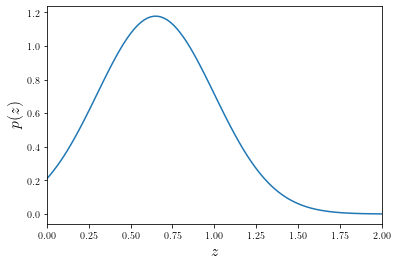

In [3]:
LOC_PRIOR = 0.65
SCALE_PRIOR = 0.35
PRIOR_MIN = (Z_TRUE_MIN-LOC_PRIOR)/SCALE_PRIOR
PRIOR_MAX = (Z_TRUE_MAX-LOC_PRIOR)/SCALE_PRIOR

implicit_prior = qp.Ensemble(qp.stats.truncnorm, data=dict(a=PRIOR_MIN, b=PRIOR_MAX, loc=LOC_PRIOR, scale=SCALE_PRIOR))
ax_prior = implicit_prior.plot(xlim=(Z_TRUE_MIN, Z_TRUE_MAX), label=r"unnorm")

## A physical model of redshift and data $p(z, d)$

Now we try a simplistic model for the behavior of the space of photometry and redshift $p(z, d)$.
$d$ would be multidimensional in real life, one dimension per photometric filter, but we're assuming a special projection of the photometry into a univariate $d$.

### Likelihoods $p(d | z)$ under the physical model

A likelihood $p(d | z)$ in this space would correspond to a distribution over possible data $d$ for a true value $z$.

`like_estim` is $\mathcal{L}(d | z_{\rm true})$   # This is both a `qp.Ensemble` with 50 PDFs and also does the lookup to map $z_{\rm true}$ -> $i$.

**Note: `likelihood` and `like_estim` might be better named `like_binned`/`like_discrete` and `like_continuous`/`like_true` respectively**

In [5]:
# This represents the true model of photometry and redshift, we define 50 bins (in true redshift)
# and in each bin the likelihood p(z_obs) is a Gaussian centered on the bin center
N_OBS_BINS = 300
Z_OBS_MIN, Z_OBS_MAX = -0.5, 2.5
N_EST_BINS = 50

z_bins = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_EST_BINS+1)
z_centers = qp.utils.edge_to_center(z_bins)
z_widths = 0.2 * np.ones(N_EST_BINS)
trunc_mins = (Z_OBS_MIN-z_centers)/z_widths
trunc_maxs = (Z_OBS_MAX-z_centers)/z_widths

data = dict(a=np.expand_dims(trunc_mins, -1),
            b=np.expand_dims(trunc_maxs, -1),
            loc=np.expand_dims(z_centers, -1),
            scale=np.expand_dims(z_widths, -1))

like_estim = qit.BinnedEnsemble(qp.stats.truncnorm, data=data, axes=[z_bins])

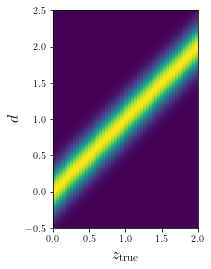

In [7]:
# These are the photometric data points at which we will evaluate posterior PDFs
N_OBS_BINS = 300
Z_OBS_MIN, Z_OBS_MAX = -0.5, 2.5
grid_edge = np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_BINS+1)
grid_cent = qp.utils.edge_to_center(grid_edge)
p_grid = like_estim.pdf(grid_cent)

plot_kwds = dict(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                 ylim=(Z_OBS_MIN, Z_OBS_MAX), 
                 xlabel=r'$z_{\rm true}$',
                 ylabel=r'$d$')
pl_like = qit.plotting.plot_2d_like(p_grid.T, **plot_kwds)

### Per-galaxy posterior distributions

Ok, now we are going to extract the posterior distributions 

The first step is to compute the product of the likelihood and the prior

for a flat prior = `post_grid` = $p(z|d)$ = $p(d|z)$

for an estimator with implicit prior $\phi^{*}$ = `est_grid` = $p(d|z) * p(z|\phi^{*})$ 

for an estimator with a very lucky implicit prior equal to the true redshift distribution = `true_grid` = $p(d|z) * p(z|\phi^{\dagger})$. 

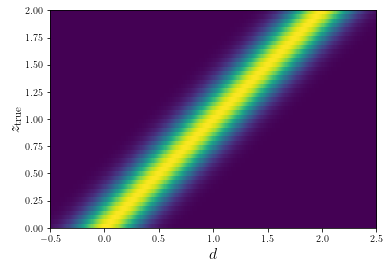

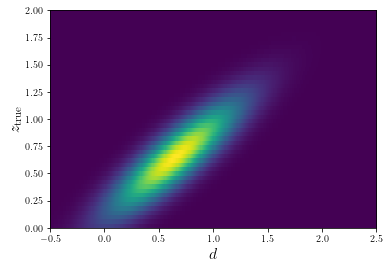

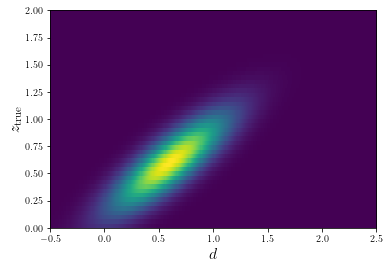

In [8]:
# Let's compute the posterior grid
z_grid = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, 101)

post_grid = like_estim.get_posterior_grid(grid_cent)
est_grid = like_estim.get_posterior_grid(grid_cent, implicit_prior)
true_grid = like_estim.get_posterior_grid(grid_cent, true_dist)

plot_kwds = dict(ylim=(Z_TRUE_MIN, Z_TRUE_MAX),
                 xlim=(Z_OBS_MIN, Z_OBS_MAX), 
                 ylabel=r'$z_{\rm true}$',
                 xlabel=r'$d$')

pl_post = qit.plotting.plot_2d_like(post_grid, **plot_kwds)
pl_est = qit.plotting.plot_2d_like(est_grid, **plot_kwds)
pl_true = qit.plotting.plot_2d_like(true_grid, **plot_kwds)

#### Posterior distributions

Now we normalize the priors of the set of $z_{\rm true}$ values to get the posteriors

for a flat prior = `flat_post` = $p(z|d)$ = $\frac{p(d|z)}{\int p(d|z) dz}$

estimated posteriors for an estimator with implicit prior $\phi^{*}$ = `est_post` = $p(z|d,\phi^{*})$ = $\frac{p(d|z) * p(z|\phi^{*})}{\int p(d|z) * p(z|\phi^{*}) dz}$

estimated posteriors for an estimator with a very lucky implicit prior equal to the true redshift distribution = `true_post` = $p(z|d,\phi^{\dagger})$ = $\frac{p(d|z) * p(z|\phi^{\dagger})}{\int p(d|z) * p(z|\phi^{\dagger}) dz}$

(101,) (50,) (50, 101) (51,)
(101,) (50,) (50, 101) (51,)
(101,) (50,) (50, 101) (51,)


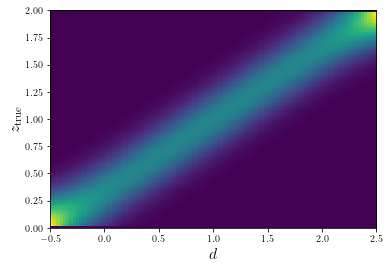

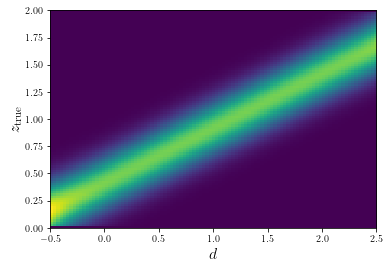

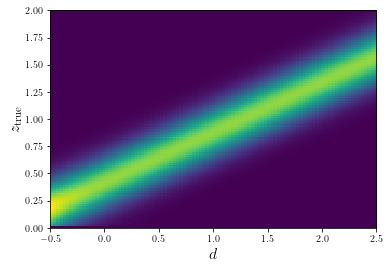

In [12]:
flat_post = qit.Posterior.create_from_grid(like_estim, z_grid)
est_post = qit.Posterior.create_from_grid(like_estim, z_grid, prior=implicit_prior)
true_post = qit.Posterior.create_from_grid(like_estim, z_grid, prior=true_dist)

pl_post_v2 = qit.plotting.plot_2d_like(flat_post.pdf(z_grid).T, **plot_kwds)
pl_est_v2 = qit.plotting.plot_2d_like(est_post.pdf(z_grid).T, **plot_kwds)
pl_true_v2 = qit.plotting.plot_2d_like(true_post.pdf(z_grid).T, **plot_kwds)

### Sample galaxy redshifts from the true redshift distribution $n^{\dagger}(z)$

Here we make a histogram of 10000 true redshifts sampled from $p(z|\phi^{\dagger})$

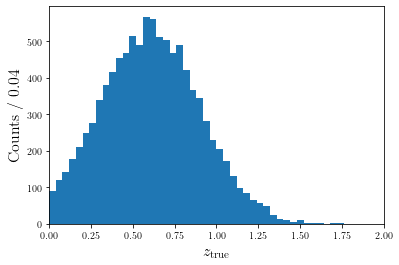

In [13]:
# Now let's sample points in true z
N_SAMPLES = 10000
N_HIST_BINS = 50
z_true_sample = np.squeeze(true_dist.rvs(size=N_SAMPLES))
fig_sample, ax_sample = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                     xlabel=r"$z_{\rm true}$",
                                                     ylabel="Counts / %0.2f" % ((Z_TRUE_MAX-Z_TRUE_MIN)/N_HIST_BINS))
hist = ax_sample.hist(z_true_sample, bins=np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_HIST_BINS+1))

### Sample data $d$ from the physical model's likelihood $p(d | z)$

We do this by sampling a $d$ value from the correct bin for each sampled value in $z_{\rm true}$.

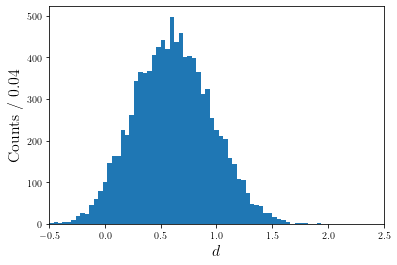

In [14]:
# Now we create a sample of points in measured z.
N_OBS_HIST_BINS = 75

sampler = like_estim.get_sampler(z_true_sample)
mask = (z_true_sample > 0) * (z_true_sample <= 2.0)
z_meas_sample = np.squeeze(sampler.rvs(1))

fig_hmeas, ax_hmeas = qp.plotting.make_figure_axes(xlim=(Z_OBS_MIN, Z_OBS_MAX),
                                                   xlabel=r"$d$",
                                                   ylabel="Counts / %0.2f" % ((Z_OBS_MAX-Z_OBS_MIN)/N_OBS_HIST_BINS))

hist = ax_hmeas.hist(z_meas_sample, bins=np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_HIST_BINS+1))

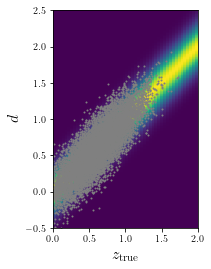

In [15]:
# Overplot the scatter plot on the 2-d likelihood plot
plot_kwds = dict(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                 ylim=(Z_OBS_MIN, Z_OBS_MAX), 
                 xlabel=r'$z_{\rm true}$',
                 ylabel=r'$d$')

pl_true = qit.plotting.plot_2d_like(p_grid.T, **plot_kwds)
ax_like2 = pl_true[1]
sc = ax_like2.scatter(z_true_sample[mask], z_meas_sample, s=1, color='gray')

### Visualizing likelihoods

The previous plot is a bit messy, lets plot the mean and std in slices of x.  (This is a "profile" plot in particle physics jargon.)

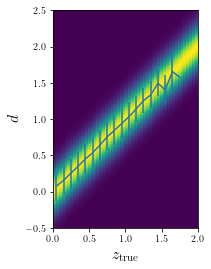

In [16]:
N_PROF_BINS = 20
pl_true2 = qit.plotting.plot_2d_like(p_grid.T, **plot_kwds)
ax_prof = pl_true2[1]
x_prof = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_PROF_BINS+1)
x_prof_cent = qp.utils.edge_to_center(x_prof)
prof_vals, prof_errs = qp.utils.profile(z_true_sample[mask], z_meas_sample, x_prof)
sc = ax_prof.errorbar(x_prof_cent, prof_vals, yerr=prof_errs)

### Posteriors for the measured "data"

Now we make "Posterior" objects

`post_p` = $p(z|d_{j})$ 

`est_p` = $p(z | d_{j}, \phi^{*})$ 

`true_p` = $p(z | d_{j}, \phi^{\dagger})$ **Suggestion: maybe rename to `lucky_p`?**

for the samples we simulated.   Note that this is different than we made the grids above.   Now the index $j$ runs over the samples, i.e., for 10000 sampled galaxies we have 10000 entries in each of `post_p`, `est_p` and `true_p`, corresponding to the posterior PDFs for each of the sampled data values $d_j$.

In [18]:
# Now we get the redshift posteriors for all the measured data
z_meas_bin = np.searchsorted(grid_edge, z_meas_sample)-1
z_meas_mask = (z_meas_bin >= 0) * (z_meas_bin < grid_cent.size)
z_meas_bin = z_meas_bin[z_meas_mask]

post_p = qit.Posterior.create_from_samples(like_estim, grid_edge, z_meas_sample)
est_p = qit.Posterior.create_from_samples(like_estim, grid_edge, z_meas_sample, prior=implicit_prior)
true_p = qit.Posterior.create_from_samples(like_estim, grid_edge, z_meas_sample, prior=true_dist)

def make_dict(post, z_grid):
    ens = post
    vals = ens.pdf(z_grid)
    return dict(post=post, ens=ens, vals=vals, stack=vals.mean(axis=0))

post_dict = make_dict(post_p, z_grid)
est_dict = make_dict(est_p, z_grid)
true_dict = make_dict(true_p, z_grid)

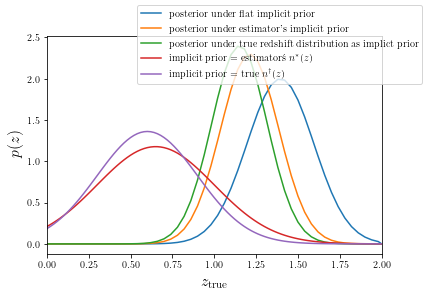

In [19]:
# Let's plot a particular event from the sample, 
# so this one galaxy's posterior under the physical model of redshift and photometry, 
# under an estimation model with implicit prior $\phi^{*}$,
# and under a (very lucky) estimation model with implicit prior $\phi^{\dagger}$
which_sample = np.argmax(z_meas_sample[0:100])
fig_x, ax_x = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                           xlabel=r"$z_{\rm true}$",
                                           ylabel=r"$p(z)$")
ax_x.plot(z_grid, post_dict['vals'][which_sample], label='posterior under flat implicit prior')
ax_x.plot(z_grid, est_dict['vals'][which_sample], label='posterior under estimator\'s implicit prior')
ax_x.plot(z_grid, true_dict['vals'][which_sample], label='posterior under true redshift distribution as implict prior')
ax_x.plot(z_grid, np.squeeze(implicit_prior.pdf(z_grid)), label=r'implicit prior = estimator\'s $n^{*}(z)$')
ax_x.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label=r'implicit prior = true $n^{\dagger}(z)$')
leg = fig_x.legend()

### Check of effect of binning the samples

This compares a histogram made from the original $d$ values to a histogram made by taking the closest grid point.  If there is working, then the two histograms should be perfectly overlaid.

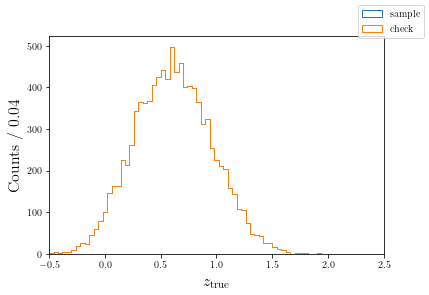

In [20]:
fig_check, ax_check = qp.plotting.make_figure_axes(xlim=(Z_OBS_MIN, Z_OBS_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel="Counts / %0.02f" % ((Z_OBS_MAX-Z_OBS_MIN)/N_OBS_HIST_BINS))

ax_check.hist(z_meas_sample, bins=np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_HIST_BINS+1), label='sample', histtype='step')
z_meas_binned = grid_cent[z_meas_bin]
ax_check.hist(z_meas_binned, bins=np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_HIST_BINS+1), label='check', histtype='step')
leg = fig_check.legend()

## Constraining the redshift distribution

### Compare the true redshift distribution to the naive "stacking"

**Note: check interpretation that either implicit prior tightens distribution relative to physical model, and that the shift in mean is due to differences between using estimated vs. true n(z) as implicit prior.**

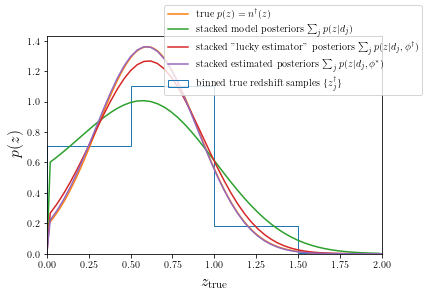

In [21]:
N_FIT_BINS = 4
hist_bins = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_FIT_BINS+1)
fig_stack, ax_stack = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z)$")
ax_stack.hist(z_true_sample[mask], bins=hist_bins, density=True, label=r'binned true redshift samples $\{z^{\dagger}_{j}\}$', histtype='step')
ax_stack.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label=r'true $p(z) = n^{\dagger}(z)$')
ax_stack.plot(z_grid, post_dict['stack'], label=r'stacked model posteriors $\sum_{j} p(z | d_{j})$')
ax_stack.plot(z_grid, est_dict['stack'], label=r'stacked "lucky estimator" posteriors $\sum_{j} p(z | d_{j}, \phi^{\dagger})$')
ax_stack.plot(z_grid, true_dict['stack'], label=r'stacked estimated posteriors $\sum_{j} p(z | d_{j}, \phi^{*})$')
leg = fig_stack.legend()


### Plot some per-galaxy redshift posterior distributions

**Note: check interpretation that implicit prior tightens distribution relative to physical model**

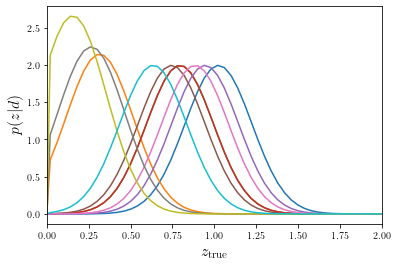

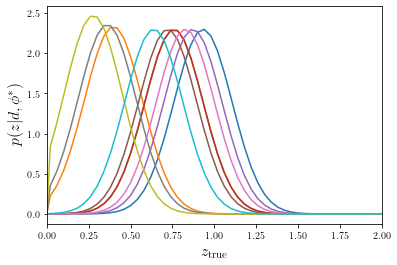

In [22]:
fig_1, ax_1 = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z | d)$")
fig_2, ax_2 = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z | d, \phi^{*})$")

post_vals = post_dict['vals']
est_vals = est_dict['vals']
for i in range(10):
    ax_1.plot(z_grid, post_vals[i])
    ax_2.plot(z_grid, est_vals[i])

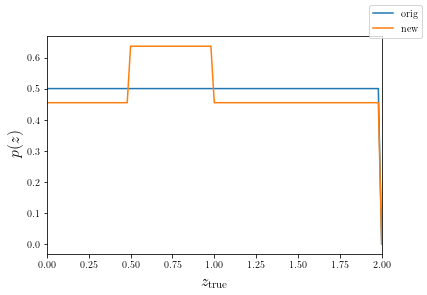

In [23]:
model_params = np.ones((1, N_FIT_BINS))
model = qp.Ensemble(qp.stats.hist, data=dict(bins=hist_bins, pdfs=model_params))
fig_model, ax_model = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z)$")

ax_model.plot(z_grid, np.squeeze(model.pdf(z_grid)), label='orig')

new_params = np.ones(N_FIT_BINS)
new_params[1] = 1.4

model.update_objdata(dict(pdfs=np.expand_dims(new_params, 0)))
ax_model.plot(z_grid, np.squeeze(model.pdf(z_grid)), label='new')
leg = fig_model.legend()

### Test to make sure we can update the parameters of a PDF for fitting

This is just a software test to make sure that setting the values of a model parameter changes the model.

### Test the likelihood function by evaluating it for a flat distribution and for the true redshift distribution

Here "model" is our model of the implicit prior

**The redshift distribution's model is some function that takes parameters $\phi$ and returns a redshift distribution $n(z) = p(z | \phi)$. There are, in nature, true values of the parameters $\phi = \phi^{\dagger}$. The implicit prior is a special value of the parameters $\phi = \phi^{*}$ corresponding to the internal workings of a redshift estimator.**

`model` = $p(z|\alpha)$ , where $\phi = \alpha$ are the hyper-parameters for ~~our prior~~ some redshift distribution $n(z) = p(z | \alpha)$

And "llike" is the likelihood associated to that model, computed by summing over the sample

**The likelihood of the parameters $\phi = \alpha$ conditioned on the data $\{d_{i}\}$ is given as follows.**

`llike` = $\sum_i \ln \int p(z|d_i, \phi^{*}) \frac{p(z|\alpha)}{p(z|\phi^{*})}  dz$

In [24]:
N_EVAL_PTS = 201
MODEL_NORM = N_SAMPLES*N_FIT_BINS/((Z_TRUE_MAX-Z_TRUE_MIN))
eval_grid = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_EVAL_PTS)
model_params = np.log(MODEL_NORM*np.ones(N_FIT_BINS)/N_FIT_BINS)
hist_cents = qp.utils.edge_to_center(hist_bins)
true_vals = np.histogram(z_true_sample, bins=np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_FIT_BINS+1))[0]
true_params = np.log(MODEL_NORM*true_vals/N_SAMPLES)
llike = qit.PriorEstimation(model, est_dict['post'], eval_grid)
v_flat = llike(model_params)
v_true = llike(true_params)
print(v_flat, v_true)

4108.773062208804 50.08219167077551


### Fit for the hyper-parameters

In [25]:
result = minimize(llike, model_params)
print(result)

      fun: -67.93909756044175
 hess_inv: array([[ 4.94988311e-04, -1.75927385e-04,  2.52755752e-04,
         2.03511009e+00],
       [-1.75927385e-04,  1.81123445e-04, -4.56347229e-04,
        -1.26536781e+00],
       [ 2.52755752e-04, -4.56347229e-04,  7.27457832e-03,
         1.34272977e+01],
       [ 2.03511009e+00, -1.26536781e+00,  1.34272977e+01,
         4.39281589e+04]])
      jac: array([-7.79829025e-02, -2.07271576e-02, -3.91864777e-02,  3.33786011e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 422
      nit: 40
     njev: 82
   status: 2
  success: False
        x: array([ 8.72524928,  9.47632079,  6.68004599, -8.92960402])


In [26]:
# Check the current value of the objective function
llike(result['x'])

-67.93909756044175

In [27]:
# Extract the parameters and convert back to counts (The Jacobian happens to be identical to the fitted values)
fitted_vals = np.exp(result['x'])
fitted_errs = np.sqrt(np.array([result['hess_inv'][i,i] for i in range(4)]))
norm_factor = 2 / fitted_vals.sum()
normed_fit = norm_factor * fitted_vals
jac = fitted_vals
# Convert to PDF, for plotting
normed_errs = norm_factor * jac * fitted_errs
model.update_objdata(dict(pdfs=np.expand_dims(normed_fit, 0)))
model_vals = np.squeeze(model.pdf(z_grid))

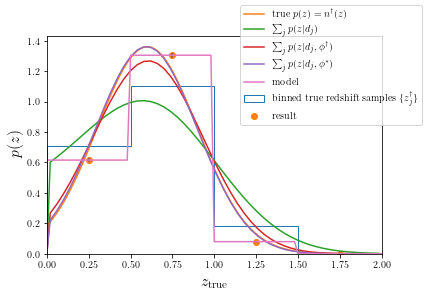

In [28]:
fig_result, ax_result = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                     xlabel=r"$z_{\rm true}$",
                                                     ylabel=r"$p(z)$")
ax_result.hist(z_true_sample[mask], bins=hist_bins, density=True, label=r'binned true redshift samples $\{z^{\dagger}_{j}\}$', histtype='step')
ax_result.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label=r'true $p(z) = n^{\dagger}(z)$')
ax_result.plot(z_grid, post_dict['stack'], label=r'$\sum_{j} p(z | d_{j})$')
ax_result.plot(z_grid, est_dict['stack'], label=r'$\sum_{j} p(z | d_{j}, \phi^{\dagger})$')
ax_result.plot(z_grid, true_dict['stack'], label=r'$\sum_{j} p(z | d_{j}, \phi^{*})$')

ax_result.scatter(hist_cents, normed_fit, label="result")
ax_result.errorbar(hist_cents, normed_fit, yerr=normed_errs, linestyle="None")
ax_result.plot(z_grid, model_vals, label='model')
leg = fig_result.legend()

# Fitting in counts space

Here we bin the data space and do the fit by computing the Poisson likelihood for the number of counts in each data bin.  

$\ln \mathcal{L} = \sum_j m_j - \sum_j d_j \log m_j$ 

where

$d_j$ is the number of data counts in bin $j$

$m_j$ is the number of model counts in bin $j$

In [29]:
N_LIKE_PTS = 301
like_grid = np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_LIKE_PTS)
#eval_bins = np.searchsorted(z_bins, eval_grid, side='left')-1
#eval_mask = (eval_bins >= 0) * (eval_bins < z_bins.size-1)
#eval_grid = eval_grid[eval_mask]
#eval_bins = eval_bins[eval_mask]
#like_eval = likelihood.pdf(like_grid)[eval_bins]
obs_cts_grid = np.linspace(Z_OBS_MIN, Z_OBS_MAX, 7)
data_hist = np.histogram(z_meas_sample, bins=obs_cts_grid)
data_cts = data_hist[0]

In [30]:
like = qit.BinnedPriorEstimation(model=model, data_hist=data_hist, likelihood=like_estim,\
                      like_grid=like_grid, model_grid=eval_grid)

In [31]:
flat = 0.5*data_cts.sum()*np.ones(4)
model_flat = like.model_counts(np.log(flat))
model_true = like.model_counts(np.log(true_vals))
ll_flat = like(np.log(flat))
ll_true = like(np.log(true_vals))
print(ll_flat, ll_true)

-63931.00351394033 -70735.53080045008


In [32]:
result = minimize(like, np.ones(4))
print(result)

      fun: -70831.3483069569
 hess_inv: array([[ 75.35964463,  75.35964463, -97.10775761,  37.22522131],
       [ 75.35964463,  75.35964463, -97.10775761,  37.22522131],
       [-97.10775761, -97.10775761, 125.13571099, -47.97168591],
       [ 37.22522131,  37.22522131, -47.97168591,  18.39275418]])
      jac: array([0.00097656, 0.00390625, 0.00195312, 0.00195312])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 410
      nit: 36
     njev: 82
   status: 2
  success: False
        x: array([ 8.09182155,  8.76794616,  5.72816128, -5.24682998])


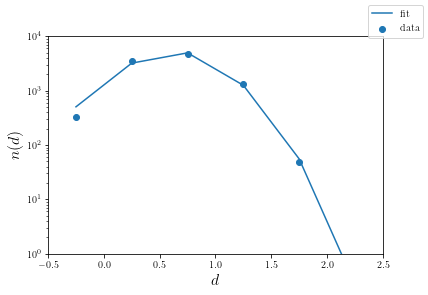

In [33]:
model_cts = like.model_counts(result['x'])
cts_cent = 0.5 * (obs_cts_grid[1:] + obs_cts_grid[:-1])
fig_fit, ax_fit = qp.plotting.make_figure_axes(xlim=(Z_OBS_MIN, Z_OBS_MAX),
                                                     xlabel=r"$d$",
                                                     ylabel=r"$n(d)$")
ax_fit.set_yscale('log')
ax_fit.set_ylim(1., 1e4)
ax_fit.scatter(cts_cent, data_cts, label='data')
ax_fit.plot(cts_cent, model_cts, label='fit')
leg = fig_fit.legend()

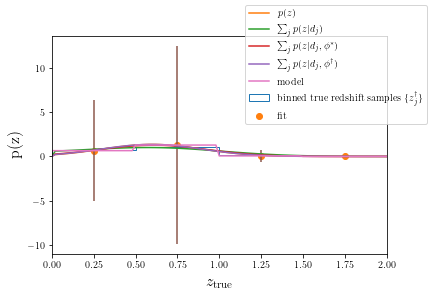

In [34]:
fit_cts = np.exp(result['x'])
fitted_errs = np.sqrt(np.array([result['hess_inv'][i,i] for i in range(4)]))
norm_factor = 2 / fit_cts.sum()
normed_fit = norm_factor * fit_cts
jac = fit_cts
normed_errs = norm_factor * jac * fitted_errs

fit_cts *= 2/fit_cts.sum()

model.update_objdata(dict(pdfs=np.expand_dims(normed_fit, 0)))
model_vals = np.squeeze(model.pdf(z_grid))

#pdf_true = true_vals * 2 / true_vals.sum()
fig_fit2, ax_fit2 = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                xlabel=r'$z_{\rm true}$',
                                                ylabel=r'p(z)')

ax_fit2.hist(z_true_sample[mask], bins=hist_bins, density=True,
             label=r'binned true redshift samples $\{z^{\dagger}_{j}\}$', histtype='step')
ax_fit2.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label=r'$p(z)$')
ax_fit2.plot(z_grid, post_dict['stack'], label=r'$\sum_j p(z | d_{j}$)')
ax_fit2.plot(z_grid, est_dict['stack'], label=r'$\sum_j p(z | d_{j}, \phi^{*})$')
ax_fit2.plot(z_grid, true_dict['stack'], label=r'$\sum_j p(z | d_{j}, \phi^{\dagger})$')

ax_fit2.errorbar(hist_cents, fit_cts, yerr=normed_errs, linestyle='None')
ax_fit2.scatter(hist_cents, fit_cts, label="fit")
ax_fit2.plot(z_grid, model_vals, label='model')
leg = fig_fit2.legend()
